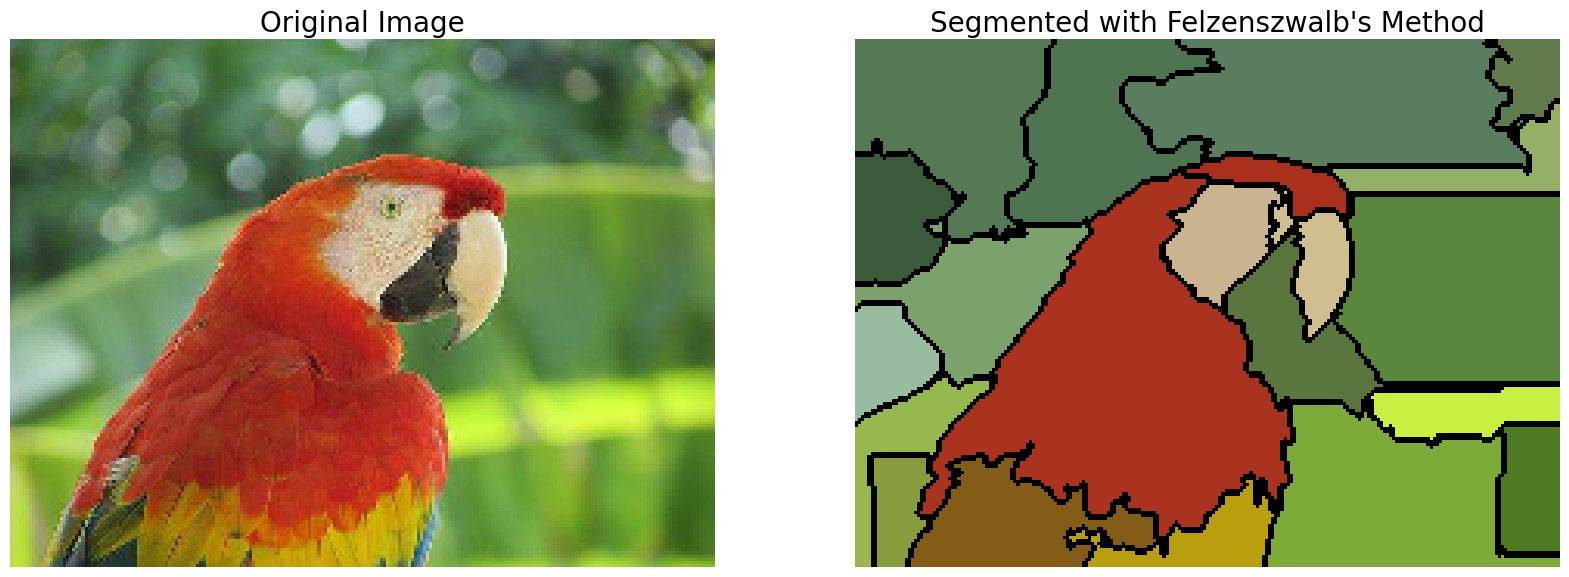

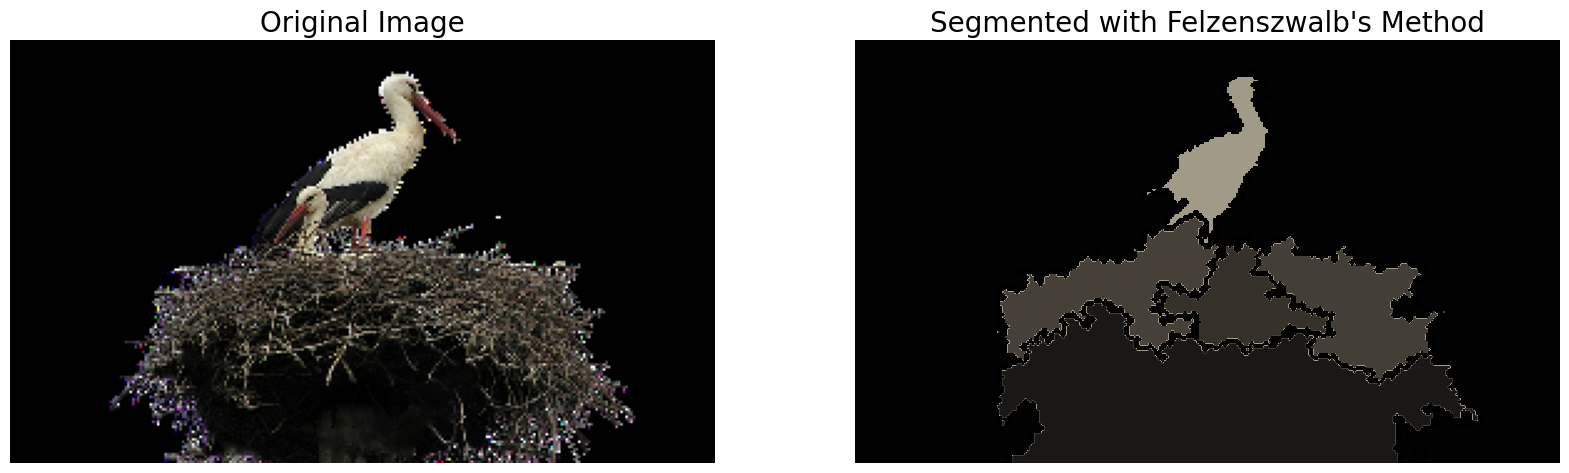

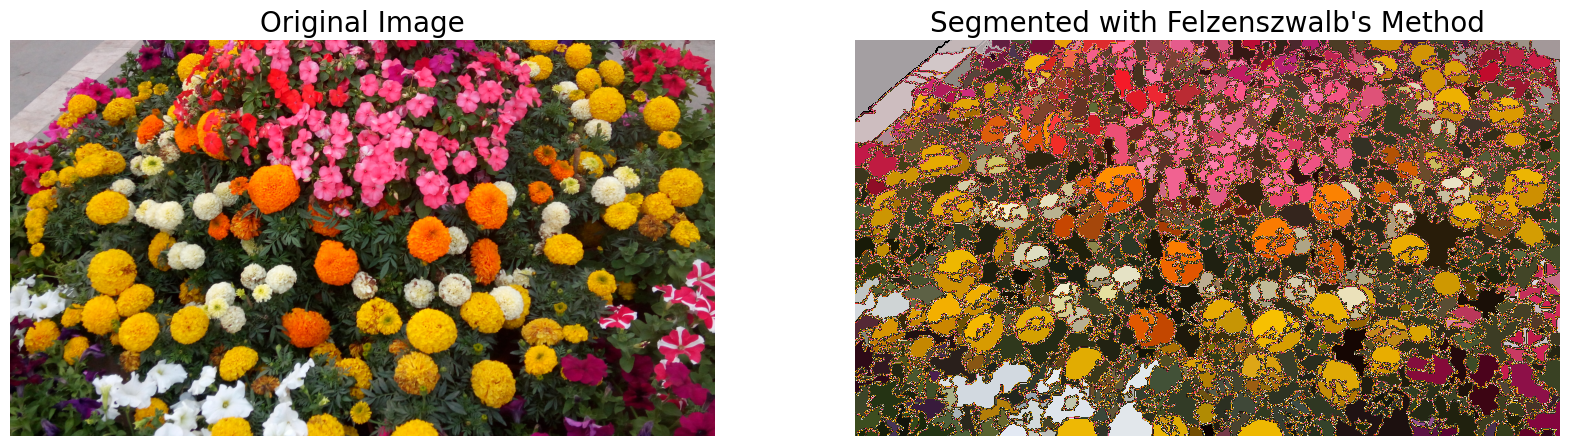

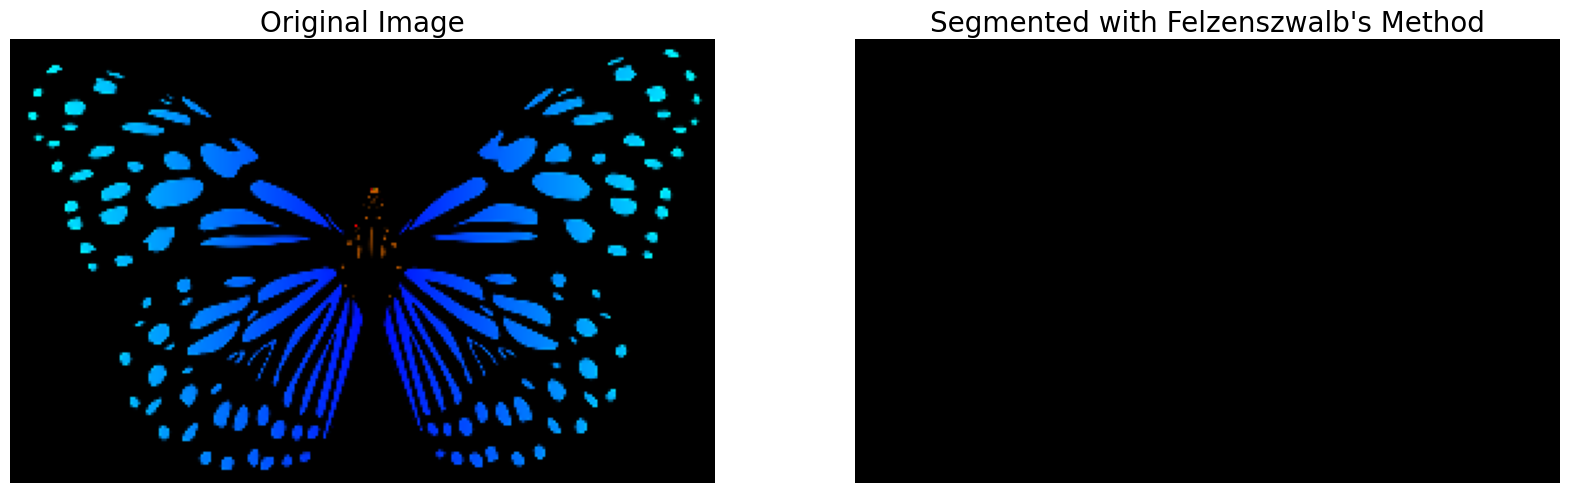

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import felzenszwalb, find_boundaries
from skimage.io import imread
from skimage.util import img_as_float
from matplotlib.colors import LinearSegmentedColormap

# Danh sách file ảnh
image_files = [
    'D:\\Learn DL\\Xử lý ảnh\\BTL\\Sandipan_Dey_2018_Sample_Images\\images\\parrot.png',
    'D:\\Learn DL\\Xử lý ảnh\\BTL\\Sandipan_Dey_2018_Sample_Images\\images\\birds.png',
    'D:\\Learn DL\\Xử lý ảnh\\BTL\\Sandipan_Dey_2018_Sample_Images\\images\\flowers.png',
    'D:\\Learn DL\\Xử lý ảnh\\BTL\\Sandipan_Dey_2018_Sample_Images\\images\\butterfly.png'
]

for imfile in image_files:
    if not os.path.exists(imfile):
        print(f"File not found: {imfile}")
        continue

    # Đọc và xử lý ảnh
    img = img_as_float(imread(imfile)[::2, ::2, :3])
    
    # Áp dụng thuật toán Felzenszwalb
    segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=400)
    
    # Xác định ranh giới
    borders = find_boundaries(segments_fz)
    unique_colors = np.unique(segments_fz.ravel())
    segments_fz[borders] = -1  # Đánh dấu ranh giới

    # Tính màu trung bình cho từng phân đoạn
    colors = [np.zeros(3)]  # Màu nền
    for color in unique_colors:
        colors.append(np.mean(img[segments_fz == color], axis=0))

    # Tạo colormap
    cm = LinearSegmentedColormap.from_list('palette', colors, N=len(colors))
    
    # Hiển thị kết quả
    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    plt.imshow(img)
    plt.title('Original Image', size=20)
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(segments_fz, cmap=cm)
    plt.title('Segmented with Felzenszwalb\'s Method', size=20)
    plt.axis('off')
    
    plt.show()


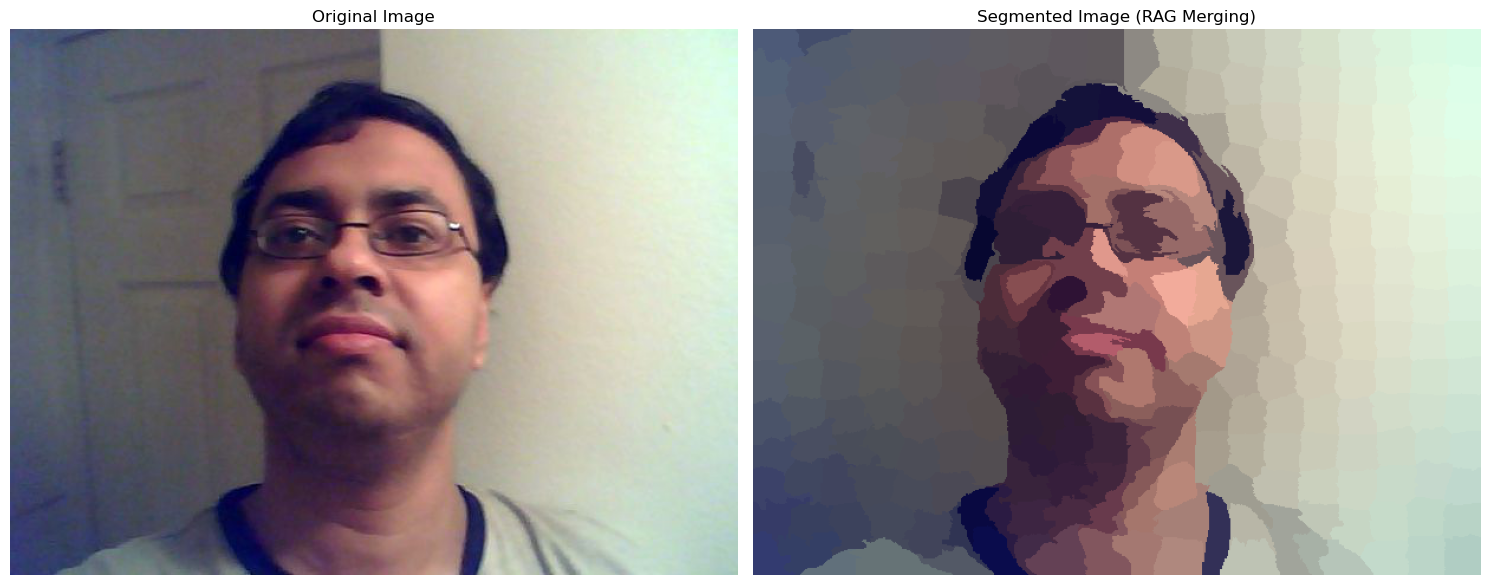

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import segmentation, color
from skimage.io import imread
from skimage.util import img_as_float
from networkx import Graph

# Đọc ảnh và chuyển đổi sang kiểu float
image = img_as_float(imread('D:\\Learn DL\\Xử lý ảnh\\BTL\\Sandipan_Dey_2018_Sample_Images\\images\\me12.jpg'))

# Phân đoạn ảnh bằng thuật toán SLIC
segments_slic = segmentation.slic(image, n_segments=300, compactness=10, start_label=1)

# Hàm xây dựng đồ thị dựa trên màu trung bình của các vùng
def build_rag(image, segments):
    rag = Graph()  # Sử dụng đồ thị từ networkx
    for region in np.unique(segments):
        mask = segments == region
        mean_color = np.mean(image[mask], axis=0)
        rag.add_node(region, mean_color=mean_color, pixel_count=np.sum(mask), total_color=np.sum(image[mask], axis=0))

    # Liên kết các vùng lân cận
    for y in range(image.shape[0] - 1):
        for x in range(image.shape[1] - 1):
            src = segments[y, x]
            neighbors = {segments[y + 1, x], segments[y, x + 1]}  # Lấy các vùng lân cận
            for dst in neighbors:
                if src != dst:
                    rag.add_edge(src, dst)

    return rag

# Hàm tính trọng số (dựa trên độ khác biệt màu trung bình giữa các vùng)
def weight_mean_color(graph, src, dst):
    diff = graph.nodes[src]['mean_color'] - graph.nodes[dst]['mean_color']
    return np.linalg.norm(diff)

# Hợp nhất các vùng
def merge_regions(graph, src, dst):
    graph.nodes[dst]['total_color'] += graph.nodes[src]['total_color']
    graph.nodes[dst]['pixel_count'] += graph.nodes[src]['pixel_count']
    graph.nodes[dst]['mean_color'] = graph.nodes[dst]['total_color'] / graph.nodes[dst]['pixel_count']
    graph.remove_node(src)

# Xây dựng đồ thị RAG
rag = build_rag(image, segments_slic)

# Lặp qua các cạnh trong đồ thị, hợp nhất các vùng có trọng số nhỏ hơn ngưỡng
threshold = 35
edges_to_merge = sorted(rag.edges(data=True), key=lambda x: weight_mean_color(rag, x[0], x[1]))
while edges_to_merge:
    src, dst, _ = edges_to_merge.pop(0)
    if src in rag.nodes and dst in rag.nodes:  # Kiểm tra xem các node có tồn tại
        if weight_mean_color(rag, src, dst) < threshold:
            merge_regions(rag, src, dst)
            # Cập nhật danh sách cạnh sau mỗi lần hợp nhất
            edges_to_merge = sorted(rag.edges(data=True), key=lambda x: weight_mean_color(rag, x[0], x[1]))

# Chuyển đổi nhãn vùng thành ảnh màu
out_image = color.label2rgb(segments_slic, image, kind='avg', bg_label=0)

# Hiển thị ảnh gốc và ảnh sau khi phân đoạn
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(out_image)
ax[1].set_title('Segmented Image (RAG Merging)')
ax[1].axis('off')

plt.tight_layout()
plt.show()


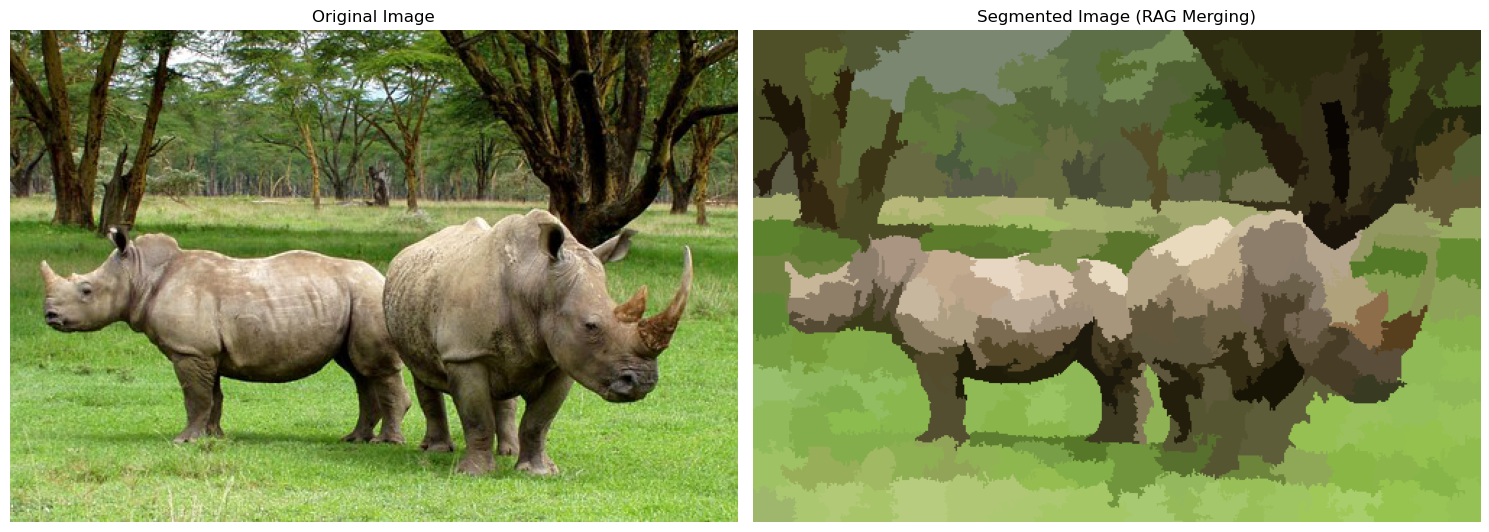

In [8]:
# Đọc ảnh và chuyển đổi sang kiểu float
image = img_as_float(imread('D:\\Learn DL\\Xử lý ảnh\\BTL\\Sandipan_Dey_2018_Sample_Images\\images\\rhino.jpg'))

# Phân đoạn ảnh bằng thuật toán SLIC
segments_slic = segmentation.slic(image, n_segments=300, compactness=10, start_label=1)

# Hàm xây dựng đồ thị dựa trên màu trung bình của các vùng
def build_rag(image, segments):
    rag = Graph()  # Sử dụng đồ thị từ networkx
    for region in np.unique(segments):
        mask = segments == region
        mean_color = np.mean(image[mask], axis=0)
        rag.add_node(region, mean_color=mean_color, pixel_count=np.sum(mask), total_color=np.sum(image[mask], axis=0))

    # Liên kết các vùng lân cận
    for y in range(image.shape[0] - 1):
        for x in range(image.shape[1] - 1):
            src = segments[y, x]
            neighbors = {segments[y + 1, x], segments[y, x + 1]}  # Lấy các vùng lân cận
            for dst in neighbors:
                if src != dst:
                    rag.add_edge(src, dst)

    return rag

# Hàm tính trọng số (dựa trên độ khác biệt màu trung bình giữa các vùng)
def weight_mean_color(graph, src, dst):
    diff = graph.nodes[src]['mean_color'] - graph.nodes[dst]['mean_color']
    return np.linalg.norm(diff)

# Hợp nhất các vùng
def merge_regions(graph, src, dst):
    graph.nodes[dst]['total_color'] += graph.nodes[src]['total_color']
    graph.nodes[dst]['pixel_count'] += graph.nodes[src]['pixel_count']
    graph.nodes[dst]['mean_color'] = graph.nodes[dst]['total_color'] / graph.nodes[dst]['pixel_count']
    graph.remove_node(src)

# Xây dựng đồ thị RAG
rag = build_rag(image, segments_slic)

# Lặp qua các cạnh trong đồ thị, hợp nhất các vùng có trọng số nhỏ hơn ngưỡng
threshold = 35
edges_to_merge = sorted(rag.edges(data=True), key=lambda x: weight_mean_color(rag, x[0], x[1]))
while edges_to_merge:
    src, dst, _ = edges_to_merge.pop(0)
    if src in rag.nodes and dst in rag.nodes:  # Kiểm tra xem các node có tồn tại
        if weight_mean_color(rag, src, dst) < threshold:
            merge_regions(rag, src, dst)
            # Cập nhật danh sách cạnh sau mỗi lần hợp nhất
            edges_to_merge = sorted(rag.edges(data=True), key=lambda x: weight_mean_color(rag, x[0], x[1]))

# Chuyển đổi nhãn vùng thành ảnh màu
out_image = color.label2rgb(segments_slic, image, kind='avg', bg_label=0)

# Hiển thị ảnh gốc và ảnh sau khi phân đoạn
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(out_image)
ax[1].set_title('Segmented Image (RAG Merging)')
ax[1].axis('off')

plt.tight_layout()
plt.show()


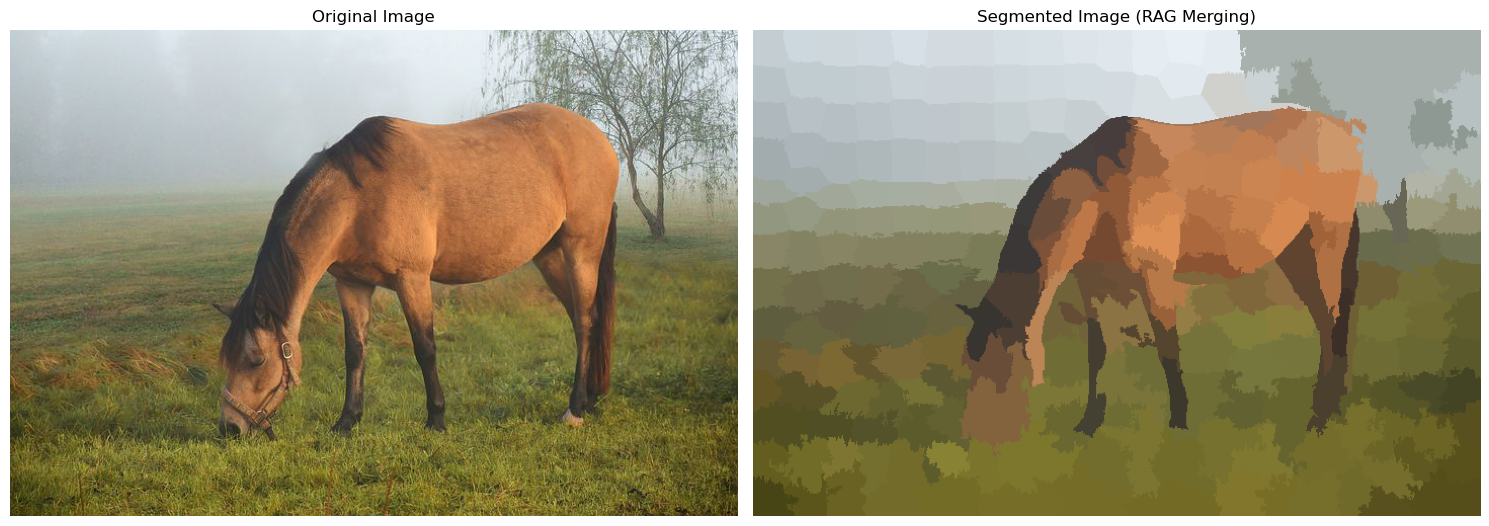

In [9]:
# Đọc ảnh và chuyển đổi sang kiểu float
image = img_as_float(imread('D:\\Learn DL\\Xử lý ảnh\\BTL\\Sandipan_Dey_2018_Sample_Images\\images\\horses.jpg'))

# Phân đoạn ảnh bằng thuật toán SLIC
segments_slic = segmentation.slic(image, n_segments=300, compactness=10, start_label=1)

# Hàm xây dựng đồ thị dựa trên màu trung bình của các vùng
def build_rag(image, segments):
    rag = Graph()  # Sử dụng đồ thị từ networkx
    for region in np.unique(segments):
        mask = segments == region
        mean_color = np.mean(image[mask], axis=0)
        rag.add_node(region, mean_color=mean_color, pixel_count=np.sum(mask), total_color=np.sum(image[mask], axis=0))

    # Liên kết các vùng lân cận
    for y in range(image.shape[0] - 1):
        for x in range(image.shape[1] - 1):
            src = segments[y, x]
            neighbors = {segments[y + 1, x], segments[y, x + 1]}  # Lấy các vùng lân cận
            for dst in neighbors:
                if src != dst:
                    rag.add_edge(src, dst)

    return rag

# Hàm tính trọng số (dựa trên độ khác biệt màu trung bình giữa các vùng)
def weight_mean_color(graph, src, dst):
    diff = graph.nodes[src]['mean_color'] - graph.nodes[dst]['mean_color']
    return np.linalg.norm(diff)

# Hợp nhất các vùng
def merge_regions(graph, src, dst):
    graph.nodes[dst]['total_color'] += graph.nodes[src]['total_color']
    graph.nodes[dst]['pixel_count'] += graph.nodes[src]['pixel_count']
    graph.nodes[dst]['mean_color'] = graph.nodes[dst]['total_color'] / graph.nodes[dst]['pixel_count']
    graph.remove_node(src)

# Xây dựng đồ thị RAG
rag = build_rag(image, segments_slic)

# Lặp qua các cạnh trong đồ thị, hợp nhất các vùng có trọng số nhỏ hơn ngưỡng
threshold = 35
edges_to_merge = sorted(rag.edges(data=True), key=lambda x: weight_mean_color(rag, x[0], x[1]))
while edges_to_merge:
    src, dst, _ = edges_to_merge.pop(0)
    if src in rag.nodes and dst in rag.nodes:  # Kiểm tra xem các node có tồn tại
        if weight_mean_color(rag, src, dst) < threshold:
            merge_regions(rag, src, dst)
            # Cập nhật danh sách cạnh sau mỗi lần hợp nhất
            edges_to_merge = sorted(rag.edges(data=True), key=lambda x: weight_mean_color(rag, x[0], x[1]))

# Chuyển đổi nhãn vùng thành ảnh màu
out_image = color.label2rgb(segments_slic, image, kind='avg', bg_label=0)

# Hiển thị ảnh gốc và ảnh sau khi phân đoạn
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(out_image)
ax[1].set_title('Segmented Image (RAG Merging)')
ax[1].axis('off')

plt.tight_layout()
plt.show()
